# DCGANs

In [37]:
import tensorflow as tf
import numpy as np
import os
import time
import imageio
import glob
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from dataclasses import dataclass
from IPython import display

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPUs: ", tf.config.list_physical_devices('GPU'))

gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    device_name = '/GPU:0'
else:
    device_name = '/CPU:0'
    print("GPU not available. Using CPU.")

Num GPUs Available:  0
Available GPUs:  []
GPU not available. Using CPU.


## Define Hyperparameters
---

In [40]:
@dataclass
class DCGANConfig:
    buffer_size: int = 60000
    batch_size: int = 256
    noise_dim: int = 100
    epochs: int = 5
    num_examples_to_generate: int = 16
    checkpoint_dir: str = './training_checkpoints'

## Load Dataset

In [41]:
class DataLoader:
    def __init__(self, config: DCGANConfig):
        self.config = config

    def load_data(self):
        (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
        train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
        train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
        train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(self.config.buffer_size).batch(self.config.batch_size)
        return train_dataset

## Implement the Generator
---
Traditionally, ConvNets have been used for image classification tasks, in which the networks takes an image with the dimension *hight x width x number of color channels* as input and and—through a series of convolutional layers—outputs a single vector of class scores, with the dimensions *1 x n*, where *n* is the number of class labels. To generate an image by using the ConvNet architecture, the process is reversed, i.e., instead of taking an image and processing it into a vector, we take a vector and upsize it to an image.

Key to this process is the *transposed convolution*. Recall that regular convolution is typically used to reduce input width and height while increasing its depth. Transposed convolution goes in the reverse direction: it is used to increase the width and height while reducing depth.

The Generator starts with a noise vector *z*. Using a fully connected layer, we reshape the vector into a three-dimensional hidden layer with a small base (width × height) and large depth. Using transposed convolutions, the input is progressively reshaped such that its base grows while its depth decreases until we reach the final layer with the shape of the image we are seeking to synthesize, *28 × 28 × 1*. After each transposed convolution layer, we apply batch normalization and the *Leaky ReLU* activation function. At the final layer, we do not apply *batch normalization* and, instead of *ReLU*, we use the *tanh* activation function.

Putting it all together:
1. Take a random noise vector and reshape it into a *7 × 7 × 256* tensor through a fully connected layer.
2. Use transposed convolution, transforming the *7 × 7 × 256* tensor into a *14 × 14 × 128* tensor.
3. Apply batch normalization and the *Leaky ReLU* activation function.
4. Use transposed convolution, transforming the *14 × 14 × 128* tensor into a *14 × 14 × 64* tensor. Notice that the width and height dimensions remain unchanged; this is accomplished by setting the stride parameter in *Conv2DTranspose* to *...*.
5. Apply batch normalization and the *Leaky ReLU* activation function.
6. Use transposed convolution, transforming the *14 × 14 × 64* tensor into the output image size, *28 × 28 × 1*.
7. Apply the *tanh* activation function.

In [42]:
class Generator:
    def __init__(self, noise_dim):
        self.model = self._build_generator(noise_dim)

    def _build_generator(self, noise_dim):
        model = tf.keras.Sequential([
            layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((7, 7, 256)),
            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ])
        return model

In [46]:
config = DCGANConfig()
generator = Generator(config.noise_dim).model
generator.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 1)           │           1,600 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

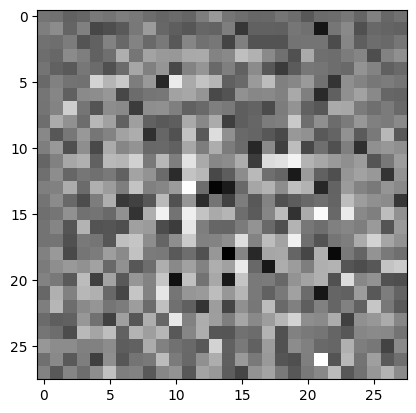

In [47]:
noise = tf.random.normal([1, config.noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

## Implement the Discriminator
---
The Discriminator is a *ConvNet* of the familiar kind, one that takes in an image and outputs a prediction vector: in this case, a binary classification indicating whether the input image was deemed to be real rather than fake. 

The input to the Discriminator is a *28 × 28 × 1* image. By applying convolutions, the image is transformed such that its base (width × height) gets progressively smaller and its depth gets progressively deeper. On all convolutional layers, we apply the *Leaky ReLU* activation function. *Batch normalization* is used on all convolutional layers except the first. For output, we use a fully connected layer and the sigmoid activation function.

Putting it all together:
1. Use a convolutional layer to transform a *28 × 28 × 1* input image into a *14 × 14 × 32* tensor.
2. Apply the *Leaky ReLU* activation function.
3. Use a convolutional layer, transforming the *14 × 14 × 32* tensor into a *7 × 7 × 64* tensor.
4. Apply *batch normalization* and the *Leaky ReLU* activation function.
5. Use a convolutional layer, transforming the *7 × 7 × 64* tensor into a *3 × 3 × 128* tensor.
6. Apply *batch normalization* and the *Leaky ReLU* activation function.
7. Flatten the *3 × 3 × 128* tensor into a vector of size *3 × 3 × 128* = *1152*.
8. Use a fully connected layer feeding into the sigmoid activation function to compute the probability of whether the input image is real.


In [48]:
class Discriminator:
    def __init__(self):
        self.model = self._build_discriminator()

    def _build_discriminator(self):
        model = tf.keras.Sequential([
            layers.Conv2D(32, kernel_size=3, strides=2, input_shape=[28, 28, 1], padding='same'),
            layers.LeakyReLU(alpha=0.01),
            layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.01),
            layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha=0.01),
            layers.Flatten(),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

In [51]:
generator = Discriminator().model
generator.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_27 (LeakyReLU)           │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_28 (LeakyReLU)           │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,489 (373.00 KB)

 Trainable params: 95,105 (371.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [52]:
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.00040679]], shape=(1, 1), dtype=float32)


## Define the loss functions and optimizers, training loop, then train!
---


In [53]:
class DCGAN:
    def __init__(self, config: DCGANConfig):
        self.config = config
        self.generator = Generator(config.noise_dim).model
        self.discriminator = Discriminator().model
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)
        self.checkpoint_prefix = os.path.join(config.checkpoint_dir, "ckpt")
        self.seed = tf.random.normal([config.num_examples_to_generate, config.noise_dim])

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([self.config.batch_size, self.config.noise_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset):
        for epoch in range(self.config.epochs):
            start = time.time()
            for image_batch in dataset:
                self.train_step(image_batch)
            display.clear_output(wait=True)
            self.generate_and_save_images(epoch + 1)
            if (epoch + 1) % 15 == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
            print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')
        display.clear_output(wait=True)
        self.generate_and_save_images(self.config.epochs)

    def generate_and_save_images(self, epoch):
        predictions = self.generator(self.seed, training=False)
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        plt.savefig(f'image_at_epoch_{epoch:04d}.png')
        plt.show()

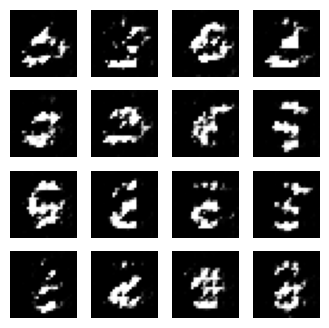

In [54]:
if __name__ == "__main__":
    config = DCGANConfig()
    data_loader = DataLoader(config)
    train_dataset = data_loader.load_data()
    dcgan = DCGAN(config)
    dcgan.train(train_dataset)
    

In [59]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('DCGANs_output/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\sulai\AppData\Local\Temp\ipykernel_31484\3410317227.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\sulai\AppData\Local\Temp\ipykernel_31484\3410317227.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



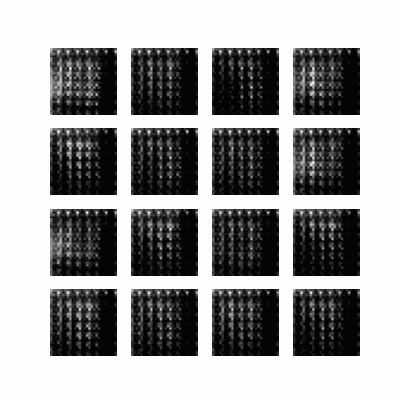

In [61]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)